In [ ]:
import sys
import os


sys.path.append("../src")


import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import sys
import os

import math

from utils import number_split, create_mix
from data_process import load_wls_adress_AddDomain
from process_SHAC import load_process_SHAC
from custom_distance import KL



from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import pickle


from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


from sentence_transformers import SentenceTransformer

from sklearn.metrics import precision_recall_fscore_support

from transformers import AutoTokenizer, AutoModel


# Test two ways of embedding... same!?

In [ ]:

model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
sentence

In [ ]:
embedding.shape

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [ ]:
encoded_input = tokenizer(sentences, max_length = 120, padding=True, truncation=True, return_tensors='pt')


In [ ]:
encoded_input

In [ ]:
with torch.no_grad():
    model_output = model(**encoded_input)


In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
model_output['last_hidden_state']

In [ ]:
# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

In [ ]:
sentence_embeddings[0]

In [ ]:
model.encode(sentences[0])

In [ ]:
model.encode(sentences[0])[:20]

In [ ]:
sentence_embeddings[0][:20]

In [ ]:
encoded_input['attention_mask']

In [ ]:
model_output[0]

# Use this Embedding

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# https://www.sbert.net/index.html

# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)


In [ ]:
embeddings.shape

# Load Data

In [ ]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

# Split

In [ ]:
n_test = 150
train_test_ratio = 4


valid_full_settings = []
for combination in itertools.product([0.1, 0.5], 
                                    [0.2, 0.6], 
                                     np.arange(0.1, 0.999, 0.1),
                                     np.arange(0, 5, 0.05)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if number_setting is not None:
        valid_full_settings.append(number_setting)
    

In [ ]:
len(valid_full_settings)

In [ ]:
valid_full_settings[0]

In [ ]:
dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= valid_full_settings[0])

In [ ]:
dfs.keys()

In [ ]:
dfs['train']

In [ ]:
dfs['test']

# Sentence BERT

## Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

## Logistic Regression

### All

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=embeddings_X_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=embeddings_X_test)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

### t-SNE

In [ ]:
embeddings_X_train

In [ ]:
x_train_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_train)
x_test_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_test)



In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tsne, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tsne)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

In [ ]:
# metrics.roc_auc_score(
#                 y_true=y_test,
#                 y_score=y_probs[:,1],
#             )

# metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

# TFIDF

In [ ]:
vectorizer = TfidfVectorizer(use_idf = True,
                                    ngram_range = (1,1))

In [ ]:
vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

In [ ]:
x_train_tfidf = vectorizer.transform(dfs['train']['text']).toarray()
x_test_tfidf = vectorizer.transform(dfs['test']['text']).toarray()

## Logistic Regression

### All features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

### t-SNE

In [ ]:
x_train_tfidf_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_train_tfidf)
x_test_tfidf_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_test_tfidf)



In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf_tsne, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf_tsne)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

In [ ]:
metrics.roc_auc_score(
                y_true=y_test,
                y_score=y_probs[:,1],
            )

In [ ]:
metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

### PCA

In [ ]:
pca = PCA(n_components=5)

In [ ]:
x_train_tfidf_pca = pca.fit_transform(x_train_tfidf)
x_test_tfidf_pca = pca.fit_transform(x_test_tfidf)


In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf_pca, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf_pca)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

# Confound: statistical adjustment

## One-hot vector for z

In [ ]:
v = 1
confound_map = {"wls":0, "adress":v}

dfs['train']['confound'] = dfs['train']['domain'].map(confound_map)

dfs['test']['confound'] = dfs['test']['domain'].map(confound_map)


## Sentence BERT

### Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

### Logistic Regression

#### All Features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
embeddings_X_train

In [ ]:
x_embeddings_confound_train = np.concatenate([embeddings_X_train, np.array(dfs['train']['confound']).reshape(-1,1)], axis=1)


In [ ]:
shape_test = embeddings_X_test.shape

a = np.empty((shape_test[0],1))
a.fill(0)
x_embeddings_confound_test_z0 = np.concatenate([embeddings_X_test, a], axis=1)

a = np.empty((shape_test[0],1))
a.fill(v)
x_embeddings_confound_test_z1 = np.concatenate([embeddings_X_test, a], axis=1)

In [ ]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs_z0 = clf.predict_proba(X=x_embeddings_confound_test_z0)
y_probs_z1 = clf.predict_proba(X=x_embeddings_confound_test_z1)

In [ ]:
p_z = []

# NOTE: the order here is important!!! Here, wls -> df0, adress -> df1
p_z.append(sum(dfs['train']['domain'] == 'wls')/len(dfs['train']))
p_z.append(sum(dfs['train']['domain'] == 'adress')/len(dfs['train']))


In [ ]:
p_z

In [ ]:
y_probs_z0[:5,:]

In [ ]:
y_probs_z0[:5,:] * p_z[0]

In [ ]:
y_probs_z1[:5,:]

In [ ]:
y_probs_z1[:5,:] * p_z[1]

In [ ]:
y_probs_confound = y_probs_z0 * p_z[0] + y_probs_z1 * p_z[1]

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

# Confound: statistical adjustment

## Dummy Coding for z

In [ ]:
z_Categories = ["wls","adress"]
n_zCats = len(z_Categories)

y_Categories = [0,1]
n_yCats = len(y_Categories)

In [ ]:
pd.Categorical(dfs['train']['domain'], categories=z_Categories)

In [ ]:
pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v

In [ ]:
confounders_train = pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v
confounders_test = pd.get_dummies(pd.Categorical(dfs['test']['domain'], categories=z_Categories), prefix="confounder") * v


## Sentence BERT

### Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

n_test = len(y_test)

In [ ]:
n_test

### Logistic Regression

#### All Features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
embeddings_X_train

In [ ]:

x_embeddings_confound_train = np.concatenate([embeddings_X_train, confounders_train], axis=1)


In [ ]:
len(z_Categories)

In [ ]:
a = np.empty(())

In [ ]:
x_embeddings_confound_test_ls = []

for i in range(n_zCats):
    

    a = np.empty((n_test, n_zCats))
    a.fill(0)
    a[:,i] = v
    _ = np.concatenate([embeddings_X_test, a], axis=1)
    x_embeddings_confound_test_ls.append(_)

In [ ]:
x_embeddings_confound_test_ls[0]

In [ ]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs_ls = []

for i in range(n_zCats):
    _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
    y_probs_ls.append(_y_probs)


In [ ]:
p_z = []

for i in z_Categories:
    p_z.append(sum(dfs['train']['domain'] == i)/len(dfs['train']))

In [ ]:
p_z

In [ ]:
y_probs_confound = np.empty((n_test, n_yCats))
y_probs_confound.fill(0)

In [ ]:
for i in range(n_zCats):
    y_probs_confound += y_probs_ls[i] * p_z[i]

In [ ]:
y_probs_confound = y_probs_ls[0] * p_z[0] + y_probs_ls[1] * p_z[1]

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

# Build for multiple runs

## WLS/Pitts

In [ ]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

## SHAC

In [ ]:
df_shac = load_process_SHAC(replaceNA="all")

In [ ]:
df_shac

In [ ]:
df_shac_uw = df_shac.query("location == 'uw'").reset_index(drop=True)
df_shac_mimic = df_shac.query("location == 'mimic'").reset_index(drop=True)


In [ ]:
df_shac.groupby(["location",]).size()

In [ ]:
df_shac.groupby(["location","Drug"]).size()

## SHAC LLaMa Embeddings - Averaged

In [ ]:
with open("../output/LLaMaEmbeddings/df_Average_SHAC.pkl", "rb") as f:
    df = pickle.load(f)

In [ ]:
df_shac_llama_average_uw = df.query("location == 'uw'").reset_index(drop=True)
df_shac_llama_average_mimic = df.query("location == 'mimic'").reset_index(drop=True)


## IMDB Horror vs Family

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_family.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_family = df_imdb.query("domain == 'Family'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_family.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_family.groupby("label_binary").size())

## IMDB Horror vs Documentary

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_documentary.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_documentary = df_imdb.query("domain == 'Documentary'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_documentary.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_documentary.groupby("label_binary").size())

In [ ]:
500/776

## IMDB Horror vs non Horror

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_nonhorror.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_nonhorror = df_imdb.query("domain == 'nonHorror'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_nonhorror.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_nonhorror.groupby("label_binary").size())

In [ ]:
10/18

In [ ]:
# del df_imdb_horror, df_imdb_nonhorror, df_imdb, df_imdb_family, df_imdb_documentary

In [ ]:
valid_full_settings[0]['mix_param_dict']

In [ ]:
 "_".join([str(x) for x in valid_full_settings[0]['mix_param_dict']])

In [ ]:
"_".join([f"{k}_{v:.4f}" for k,v in valid_full_settings[0]['mix_param_dict'].items()])

## Yelp Seafoof: FL vs PA

In [ ]:
df_FL = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_FL.csv")
df_PA = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_PA.csv")

## Yelp Mexican: AZ vs MO

In [ ]:
df_AZ = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_AZ.csv")
df_MO = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_MO.csv")

## Yelp Year: before(and in) 2015 vs after(and in) 2020

In [ ]:
df_before2015 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_before2015.csv")
df_after2020 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_after2020.csv")

## Hate Speech

In [ ]:
import pathlib

In [ ]:
df_dynGen = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/Dynamically-Generated-Hate-Speech-Dataset/Dynamically Generated Hate Dataset v0.2.3.csv",)
df_dynGen['label_binary'] = df_dynGen['label'].map({"hate":1, "nothate":0})

In [ ]:
df_dynGen["dfSource"] = "dynGen"

In [ ]:
df_dynGen['label'].unique()

In [ ]:
df_dynGen['label_binary'].unique()

In [ ]:
ls_allFiles = pathlib.Path("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/all_files/").glob("*.txt")

ls_id = []
ls_text = []

for ifile in ls_allFiles:
    ls_id.append(ifile.name.split(".txt")[0])
    with open(ifile, "r") as f:
        ls_text.append(f.read())

df_wsf_raw = pd.DataFrame({"file_id":ls_id, "text":ls_text})

df_wsf_annotation = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/annotations_metadata.csv")

df_wsf = df_wsf_raw.merge(df_wsf_annotation, on="file_id", how="inner")

In [ ]:
df_wsf.head()

In [ ]:
df_wsf['label'].unique()

In [ ]:
df_wsf = df_wsf[df_wsf['label'].isin(['hate','noHate'])].reset_index(drop=True)

df_wsf['label_binary'] = df_wsf['label'].map({"hate":1,"noHate":0})

In [ ]:
df_wsf['label_binary'].unique()

In [ ]:
df_wsf["dfSource"] = "wsf"

In [ ]:
df_yt = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/HS_YouTube/IMSyPP_EN_YouTube_comments_evaluation_context.csv")


In [ ]:
df_yt.groupby(['Type'],  dropna=False).size()

In [ ]:
df_yt = df_yt.query("Type.isin(['0. appropriate', '2. offensive'])").reset_index(drop=True)

df_yt['label_binary'] = df_yt['Type'].map({"2. offensive":1, "0. appropriate": 0})

In [ ]:
df_yt.groupby("label_binary", dropna=False).size()

In [ ]:
df_yt = df_yt.rename(columns={"Text":"text"})

## WILDS

In [ ]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="civilcomments", download=True)


In [ ]:
# Get the test set
train_data = dataset.get_subset("train")
train_loader = get_train_loader("standard", train_data, batch_size=16)


In [ ]:
dataset.metadata_fields

In [ ]:
from wilds.common.grouper import CombinatorialGrouper
# grouper = CombinatorialGrouper(dataset, dataset.metadata_fields[:8])


# z_var = "christian"
# z_var = "white"
z_var = "male"


grouper = CombinatorialGrouper(dataset, [z_var])

In [ ]:
x_ls = []
y_true_ls = []
metadata_ls = []

for labeled_batch in train_loader:
    x, y_true, metadata = labeled_batch
    x_ls.extend(x)
    y_true_ls.extend(y_true.numpy())
    metadata_ls.append(metadata)

In [ ]:
df = pd.DataFrame({"text": x_ls, "y_true":y_true_ls,})

metadata_df = pd.DataFrame(torch.concat(metadata_ls).numpy())
metadata_df.columns = dataset.metadata_fields

In [ ]:
df = pd.concat([df, metadata_df], axis=1)

In [ ]:
df

In [ ]:
df.groupby([z_var, "y_true"], dropna=False).size()

In [ ]:
df['Christian'] = np.where(df['christian'] == 1, "christian", "nonchristian")

In [ ]:
df_christian = df.query("christian == 1").reset_index(drop=True)
df_nonchristian = df.query("christian == 0").reset_index(drop=True)

In [ ]:
df_christian.shape

In [ ]:
df_nonchristian.shape

In [ ]:
df['White'] = np.where(df['white'] == 1, "white", "notwhite")

In [ ]:
df_white = df.query("white == 1").reset_index(drop=True)
df_notwhite = df.query("white == 0").reset_index(drop=True)

In [ ]:
df_white.shape

In [ ]:
df_notwhite.shape

In [ ]:
df['Male'] = np.where(df['male'] == 1, "male", "notmale")

In [ ]:
df_male = df.query("male == 1").reset_index(drop=True)
df_notmale = df.query("male == 0").reset_index(drop=True)

In [ ]:
df_male.shape

In [ ]:
df_notmale.shape

# Split

In [ ]:
# p_pos_train = p_pos_train_z0 * p_mix_z0 + p_pos_train_z1 * p_mix_z1 = 0.5

# p_pos_train = p_pos_test



In [ ]:
# SHAC-Drug - full, long experiments
n_test = 500
train_test_ratio = 4

p_pos_train_z0=0.2
p_pos_train_z1=0.5

valid_full_settings = []
for combination in itertools.product([p_pos_train_z0], 
                                     [p_pos_train_z1], 
                                     np.arange(0.01, 0.99, 0.01),
                                     np.arange(0, 5, 0.01)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# SHAC-Drug - for short experiments! n_test = 500 -- AMIA
n_test = 500
train_test_ratio = 4


p_pos_train_z0=0.5
p_pos_train_z1=0.2

valid_full_settings = []
for combination in itertools.product([p_pos_train_z0], 
                                     [p_pos_train_z1], 
                                     [0.3,0.5,0.6],
                                     np.arange(0, 5, 0.1)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# SHAC-Drug - for short experiments! n_test = 500 -- test
n_test = 500
train_test_ratio = 4


p_pos_train_z0=0.5
p_pos_train_z1=0.2
numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product([p_pos_train_z0], 
                                     [p_pos_train_z1], 
                                     [0.3,0.5,0.6],
                                     alpha_test_ls,
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# SHAC-Drug - Balanced Alpha
n_test = 500
train_test_ratio = 4


p_pos_train_z0_ls = np.arange(0, 1, 0.1) # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = np.arange(0, 1, 0.1) # probability of test set examples drawn from site/domain z1 being positive


p_mix_z1_ls     = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    
    

In [ ]:
# # imdb setting
# n_test = 500
# train_test_ratio = 4

p_pos_train_z0 = 0.3
p_pos_train_z1 = 0.5

# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.1)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [ ]:
# # yelp seafood PA vs FL setting
# n_test = 500
# train_test_ratio = 4


p_pos_train_z0 = 0.8
p_pos_train_z1 = 0.6

# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [ ]:
# # yelp mexican AZ vs MO setting
# n_test = 500
# train_test_ratio = 4

p_pos_train_z0 = 0.65
p_pos_train_z1 = 0.5


# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [ ]:
# # yelp year before 2015 vs after 2020 setting
# n_test = 10000
# train_test_ratio = 4


p_pos_train_z0 = 0.3
p_pos_train_z1 = 0.9

# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.1),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [ ]:
df_dynGen.shape

In [ ]:
df_wsf.shape

In [ ]:
# Hate Speech Detection: df_dynGen (0.55) vs df_wsf (0.11)
n_test = 1000
train_test_ratio = 4


p_pos_train_z0_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.2, 0.4, 0.6, 0.8] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# WILDS: CivilComments
# by Christian: df_christian (0.11) vs df_nonchristian (0.11)
# by White: df_white vs df_notwhite
# by Male: df_male vs df_notmale

n_test = 500
train_test_ratio = 4


p_pos_train_z0_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.2, 0.4, 0.6, 0.8] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
len(valid_full_settings)

In [ ]:
test_settings = []
for one_setting in valid_full_settings:
    # _a = round(one_setting['mix_param_dict']['p_mix_z1'],2) == 0.2
    _c = one_setting['mix_param_dict']['alpha_test'] == 5
    
    if _c:
        test_settings.append(one_setting)

In [ ]:
len(test_settings)

In [ ]:
valid_full_settings[0]

In [18]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_full_settings])

<AxesSubplot:xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

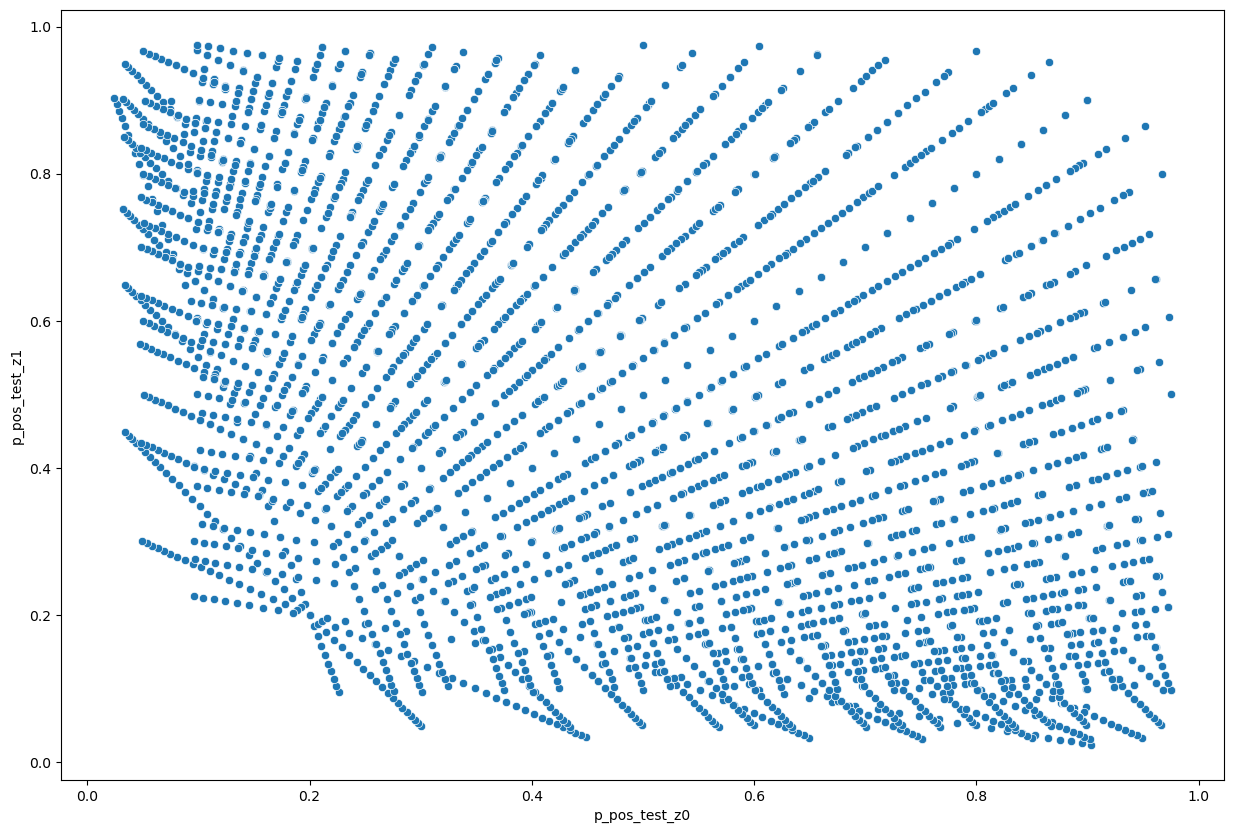

In [19]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)

In [20]:
# run for check valid settings

import warnings; warnings.simplefilter('ignore')

# label='label_binary'
# df0 = df_dynGen
# df1 = df_wsf

# label='Drug'
# df0 = df_shac_uw
# df1 = df_shac_mimic

label='y_true'
# df0 = df_christian
# df1 = df_nonchristian
# df0 = df_white
# df1 = df_notwhite
df0 = df_male
df1 = df_notmale

valid_n_full_settings = []

for c in tqdm(valid_full_settings):
    # for c in test_settings:


        c = c.copy()
        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=222
                        )

        if dfs is None:
            continue
        
        valid_n_full_settings.append(c)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4556/4556 [03:31<00:00, 21.53it/s]


In [21]:
len(valid_n_full_settings)

4556

In [22]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_n_full_settings])

<AxesSubplot:xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

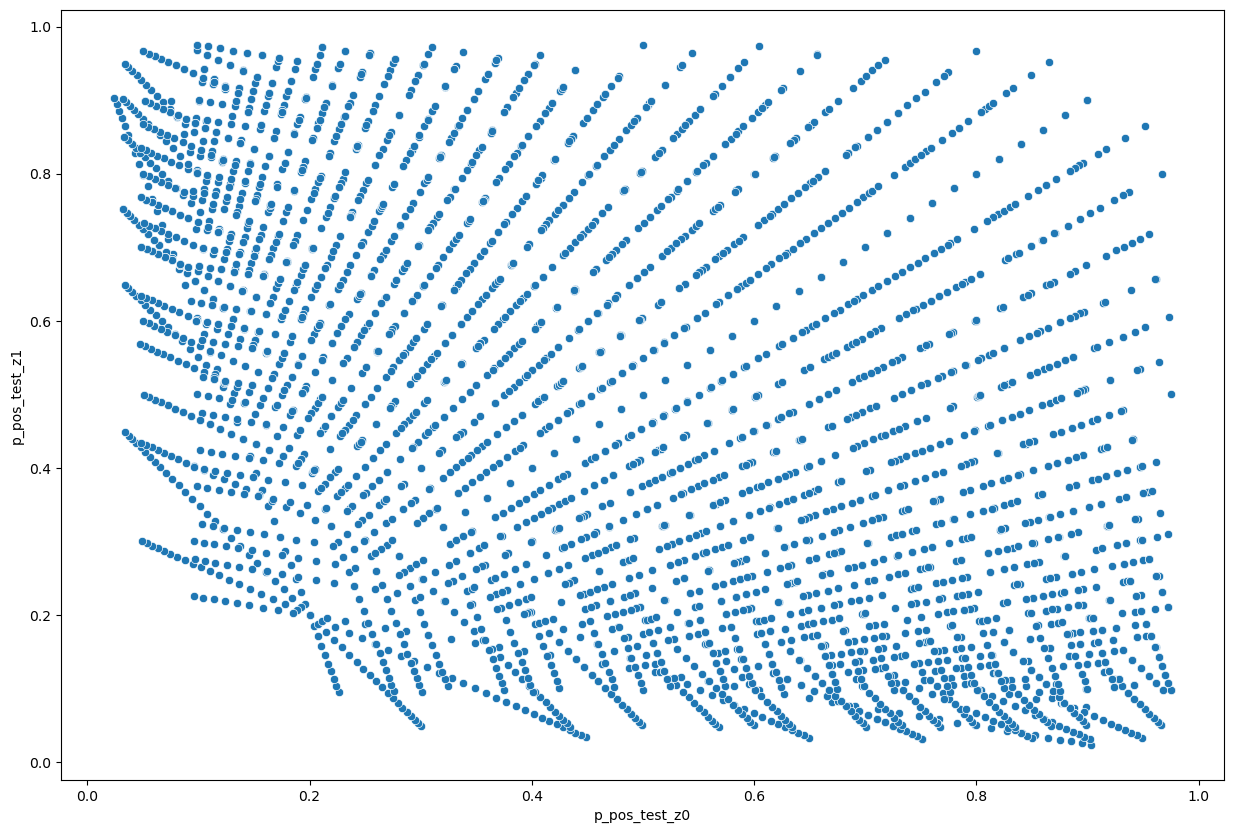

In [23]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)

# Logistic Regression

In [ ]:
# transform = "Sentence-BERT"
transform = "binaryUnigram"


model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["wls","adress"]
# label='label'



# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic

z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic


# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)

# add confounder. v is the scale for confounder
v = 100

# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# C=1
penalty = "l2"
solver = "lbfgs"
C = 5


random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_vanilla = []
valid_n_full_settings = []

for iRun in range(5):
    
    

    _rand = random.randint(0, 2**32 - 1)
    print(_rand)
    
    print(iRun)
    for c in tqdm(valid_full_settings):
    # for c in test_settings:


        c = c.copy()
        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=_rand
                        )

        if dfs is None:
            continue
        c['run'] = iRun
        valid_n_full_settings.append(c)
        

        if transform == "Sentence-BERT":
            # use Sentence-BERT to encode sentences
            x_transform_train = model.encode(dfs['train'][txt_col])
            x_transform_test = model.encode(dfs['test'][txt_col])
        if transform == "binaryUnigram":
            x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
            x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()

    # tfidf could be tricky...
    # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
    #     elif transform == "tfidf":
    #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

    #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

    #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
    #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

        y_train = dfs['train'][label]
        y_test = dfs['test'][label]

        n_test = len(y_test)




        confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
        confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


        #####################  Confound: statistical Adjustment
        clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

        # for training set: add confounder as dummy variables
        x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

        # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
        x_embeddings_confound_test_ls = []

        for i in range(n_zCats):
            a = np.empty((n_test, n_zCats))
            a.fill(0)
            a[:,i] = v
            _ = np.concatenate([x_transform_test, a], axis=1)
            x_embeddings_confound_test_ls.append(_)


        # fit the training data, add confounding dummy variables as predictors
        clf.fit(X=x_embeddings_confound_train, y=y_train)

        # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
        y_probs_ls = []

        for i in range(n_zCats):
            _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
            y_probs_ls.append(_y_probs)


        # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
        p_z = []

        for i in z_Categories:
            p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


        # calculate P(Y|X): sum(P(y|x,z) * P(z))
        y_probs_confound = np.empty((n_test, n_yCats))
        y_probs_confound.fill(0)

        for i in range(n_zCats):
            y_probs_confound += y_probs_ls[i] * p_z[i]



        auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))


        #####################  Simple Logistic Regression, WITHOUT confounder
        clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

        clf_vanilla.fit(X=x_transform_train, y=y_train)


        y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


        auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))


############  Put Results in DataFrame, with extra information (a little redundant)

# organize results in DataFrame
df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                        "auprc_logistic_vanilla": auprc_logistic_vanilla})


for k in valid_n_full_settings[0]['mix_param_dict'].keys():
    df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

for k in valid_n_full_settings[0].keys():
    if k != "mix_param_dict":
        df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

# save to file
with open(f"../output/regressionSHAC/05_02_{n_test}_{penalty}_C{C}_V{v}.pkl", "wb") as f:
    pickle.dump(df_eval, file=f)

In [ ]:
np.stack(df['LLaMaEmbeddings']).shape

## Save for AMIA

In [ ]:
#### AMIA 2023 Main


import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
transform = "Sentence-BERT"
# transform = "binaryUnigram"

# runs = 5

# model = SentenceTransformer('all-MiniLM-L6-v2')
# vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic


##### Update to Address Reviewers' comments for AMIA Paper + ClinicalBERT
# transform = "Clinical-BERT"

runs = 5

tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")

vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic


##### Test for LLaMa
# transform = "LLaMaAverage"

# runs = 5

# model = SentenceTransformer('all-MiniLM-L6-v2')
# vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic









# z_Categories = ["mimic", "uw"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_mimic
# df1 = df_shac_uw

# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)

# add confounder. v is the scale for confounder
# v = 100

# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# C=1
penalty = "l2"
solver = "lbfgs"
# C = 5


random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], [1,1],[1,100]]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings):
        # for c in test_settings:


            c = c.copy()
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            if transform == "LLaMaAverage":
                x_transform_train = np.stack(dfs['train'][txt_col])
                x_transform_test = np.stack(dfs['test'][txt_col])
            if transform == "Clinical-BERT":
                x_train_inputs = tokenizer(list(dfs['train'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                x_test_inputs = tokenizer(list(dfs['test'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                
                with torch.no_grad():
                    x_train_outputs = model(**x_train_inputs)
                    x_test_outputs = model(**x_test_inputs)

                x_transform_train = x_train_outputs['last_hidden_state'][:,0,:]
                x_transform_test = x_test_outputs['last_hidden_state'][:,0,:]

                

        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']


            confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
            confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

            # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
            x_embeddings_confound_test_ls = []

            for i in range(n_zCats):
                a = np.empty((n_test, n_zCats))
                a.fill(0)
                a[:,i] = v
                _ = np.concatenate([x_transform_test, a], axis=1)
                x_embeddings_confound_test_ls.append(_)


            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

            # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
            y_probs_ls = []

            for i in range(n_zCats):
                _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
                y_probs_ls.append(_y_probs)


            # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
            p_z = []

            for i in z_Categories:
                p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


            # calculate P(Y|X): sum(P(y|x,z) * P(z))
            y_probs_confound = np.empty((n_test, n_yCats))
            y_probs_confound.fill(0)

            for i in range(n_zCats):
                y_probs_confound += y_probs_ls[i] * p_z[i]



            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    # save to file
    # outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

## Experiments

In [ ]:
#### Crazy version....

import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
transform = "Sentence-BERT"
# transform = "binaryUnigram"

runs = 5

model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')


### Hate Speech
# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha"

### SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

### CivilComments from WILDS, by christian
# z_Categories = ["christian", "nonchristian"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Christian"
# df0 = df_christian
# df1 = df_nonchristian
# outdir = f"../output/regressionCivilComments_by_Christian"

### CivilComments from WILDS, by White
# z_Categories = ["white", "notwhite"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "White"
# df0 = df_white
# df1 = df_notwhite
# outdir = f"../output/regressionCivilComments_by_White"

### CivilComments from WILDS, by Male
z_Categories = ["male", "notmale"]  # the order here matters! Should match with df0, df1
label='y_true'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "Male"
df0 = df_male
df1 = df_notmale
outdir = f"../output/regressionCivilComments_by_Male"

# save to file
# outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
# outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"

os.makedirs(outdir, exist_ok=True)



##### Test for LLaMa
# transform = "LLaMaAverage"

# runs = 5

# model = SentenceTransformer('all-MiniLM-L6-v2')
# vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic


### IMDB
# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

### Yelp by States, AZ vs MO
# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

### Yelp by Year
# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)


# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
penalty = "l2"
solver = "lbfgs"



random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], ]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings):
        # for c in test_settings:


            c = c.copy()
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            if transform == "LLaMaAverage":
                x_transform_train = np.stack(dfs['train'][txt_col])
                x_transform_test = np.stack(dfs['test'][txt_col])
            if transform == "Clinical-BERT":
                x_train_inputs = tokenizer(list(dfs['train'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                x_test_inputs = tokenizer(list(dfs['test'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                
                with torch.no_grad():
                    x_train_outputs = model(**x_train_inputs)
                    x_test_outputs = model(**x_test_inputs)

                x_transform_train = x_train_outputs['last_hidden_state'][:,0,:]
                x_transform_test = x_test_outputs['last_hidden_state'][:,0,:]

                

        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']


            confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
            confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

            # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
            x_embeddings_confound_test_ls = []

            for i in range(n_zCats):
                a = np.empty((n_test, n_zCats))
                a.fill(0)
                a[:,i] = v
                _ = np.concatenate([x_transform_test, a], axis=1)
                x_embeddings_confound_test_ls.append(_)


            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

            # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
            y_probs_ls = []

            for i in range(n_zCats):
                _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
                y_probs_ls.append(_y_probs)


            # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
            p_z = []

            for i in z_Categories:
                p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


            # calculate P(Y|X): sum(P(y|x,z) * P(z))
            y_probs_confound = np.empty((n_test, n_yCats))
            y_probs_confound.fill(0)

            for i in range(n_zCats):
                y_probs_confound += y_probs_ls[i] * p_z[i]



            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    
    # outname = f"{outdir}/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"{outdir}/{transform}_ntest_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

224899942
0


 42%|███████████████████████████████████████▍                                                      | 1909/4556 [1:08:30<1:52:44,  2.56s/it]

In [ ]:
outname

In [ ]:
f"{outdir}/{transform}_ntest_{n_test}_{penalty}_C{C}_V{v}.pkl"


In [ ]:
df_eval['p_pos_train_z0']

In [ ]:
x_transform_train.shape

In [ ]:
len(valid_n_full_settings)

In [ ]:
df_eval

In [ ]:
df_eval['run'].unique()

In [ ]:
df_eval.shape

In [ ]:
p_z

In [ ]:
df_eval.query("(alpha_test == 5)")

## Plot results

In [ ]:
df_eval['alpha_test'].unique()

In [ ]:
df_eval['p_pos_train_z0'].unique()

In [ ]:
df_eval['p_pos_train_z1'].unique()

In [ ]:
# df = df_eval.query("(p_pos_train_z0 == 0.3) & (p_pos_train_z1 == 0.6)")
df = df_eval.copy()

In [ ]:
df['alpha_train'].unique()

In [ ]:
len(df['p_mix_z1'].unique())

In [ ]:
df

In [ ]:
# df['distance_KL_Test_Train'] = df.apply(lambda x: KL([1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
#                                                            [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']]
#                                                           ),
#                                               axis=1
#                                              )

In [ ]:
df['distance_KL_Train_Test'] = df.apply(lambda x: KL([1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                     [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                           
                                                          ),
                                              axis=1
                                             )

df['distance_KL_Test_Train'] = df.apply(lambda x: KL(
                                                     [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                     [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                           
                                                          ),
                                              axis=1
                                             )

In [ ]:
xlabel = "alpha_test"

p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,8))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    _df = df[df['p_mix_z1'] == k].sort_values("alpha_test")
    
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_confounder'], label="confounder")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_vanilla'], label="vanilla")
    
    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()
plt.tight_layout()

In [ ]:
df.columns

In [ ]:
xlabel = "alpha_test"

p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,8))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    _df = df[df['p_mix_z1'] == k].sort_values("alpha_test")
    
    # sns.lineplot(data=_df, x=xlabel, y='recall_confounder_df0', ax=ax[idx], label="confounder-df0")
    g_results=sns.lineplot(data=_df, x=xlabel, y='recall_confounder_df0', ax=ax[idx], label="confounder-df1")
    # sns.lineplot(data=_df, x=xlabel, y='recall_vanilla_df0', ax=ax[idx], label="vanilla-df0")
    g_results=sns.lineplot(data=_df, x=xlabel, y='recall_vanilla_df0', ax=ax[idx], label="vanilla-df1")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_confounder'], label="confounder")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_vanilla'], label="vanilla")
    g_results.set(xscale="log")
    
    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()
plt.tight_layout()

In [ ]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    
    ax[idx].set_xlabel(xlabel)
    ax[idx].set_ylabel("AUPRC")
    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

plt.tight_layout()

In [ ]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    
    ax[idx].set_xlabel(xlabel)
    ax[idx].set_ylabel("AUPRC")
    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

plt.tight_layout()

In [ ]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(1,1, figsize=(20,10))

xlabel = "distance_KL_Train_Test"
_df = df.sort_values(xlabel)

sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', label="confounder", alpha=0.6)
sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', label="vanilla", alpha=0.6)

# ax.plot(_df[xlabel], _df['auprc_logistic_confounder'], label="confounder", alpha=0.6)
# ax.plot(_df[xlabel], _df['auprc_logistic_vanilla'], label="vanilla", alpha=0.6)

ax.set_xlabel(xlabel)
ax.set_ylabel("AUPRC")
# ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
ax.legend()


In [ ]:

fig, ax = plt.subplots(1,2, figsize=(28,10))
xlabel = "distance_KL_Test_Train"
_df = df.sort_values(xlabel)

for idx, k in enumerate(["auprc_logistic_vanilla", "auprc_logistic_confounder"]):
    
    im = ax[idx].scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df[k], cmap='Blues')
    im.set_clim(0.8,1)
    ax[idx].set_xlabel("p_pos_test_z0")
    ax[idx].set_ylabel("p_pos_test_z1")
    ax[idx].set_title(k)

    fig.colorbar(im, ax=ax[idx])

In [ ]:
# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_confounder"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.xlabel("p_pos_test_z0")
# plt.ylabel("p_pos_test_z1")
# plt.title("AUPRC of LR with confounder")

# fig.colorbar(im, ax=ax)

# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_vanilla"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.title('vanilla LR')
# fig.colorbar(im, ax=ax)

In [ ]:
df

In [ ]:
df.query("0.67 < distance_KL_Test_Train < 0.75").sort_values("distance_KL_Test_Train")

## Check some diagnosis

### Corr Plot

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(x_transform_test).iloc[:, :].corr(), vmin=-1, vmax=1)

### R2

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_true=y_test, y_pred=y_probs_vanilla[:, 1])

In [ ]:
r2_score(y_true=y_test, y_pred=y_probs_confound[:, 1])

In [ ]:
def r2AndAdjusted(y_true, y_pred, np):
    n = len(y_true)
    
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    r2_adjusted = 1-(1-r2)*(n-1)/(n-np-1)
    
    return r2, r2_adjusted
    

In [ ]:
r2AndAdjusted(y_true=y_test, y_pred=y_probs_vanilla[:, 1], np=384)

In [ ]:
# auprc_logistic_confounder

# auprc_logistic_vanilla

In [ ]:
x_transform_train.shape

### Deviance Residuals

In [ ]:
def deviance(X, y, model):
    return 2*metrics.log_loss(y, model.predict_proba(X), normalize=False)

In [ ]:
deviance(X=x_transform_test, y=y_test, model=clf_vanilla)

### Calibration

In [ ]:
from sklearn.calibration import calibration_curve


In [ ]:
prob_true_vanilla, prob_pred_vanilla = calibration_curve(y_true=y_test, y_prob=y_probs_vanilla[:,1], n_bins=10)
prob_true_confound, prob_pred_confound = calibration_curve(y_true=y_test, y_prob=y_probs_confound[:,1], n_bins=10)


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(prob_pred_vanilla, prob_true_vanilla, label='vanilla')
ax.plot(prob_pred_confound, prob_true_confound, label='confound')

ax.plot([0,1],[0,1], "--", color='gray')
ax.legend()


In [ ]:
prob_true_vanilla_df0, prob_pred_vanilla_df0 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_prob=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1], n_bins=10)
prob_true_vanilla_df1, prob_pred_vanilla_df1 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_prob=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1], n_bins=10)

prob_true_confound_df0, prob_pred_confound_df0 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_prob=y_probs_confound[df_test[domain_col] == z_Categories[0],1], n_bins=10)
prob_true_confound_df1, prob_pred_confound_df1 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_prob=y_probs_confound[df_test[domain_col] == z_Categories[1],1], n_bins=10)



In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(prob_pred_vanilla_df0, prob_true_vanilla_df0, label='vanilla-df0')
ax.plot(prob_pred_vanilla_df1, prob_true_vanilla_df1, label='vanilla-df1')

ax.plot(prob_pred_confound_df0, prob_true_confound_df0, label='confound-df0')
ax.plot(prob_pred_confound_df1, prob_true_confound_df1, label='confound-df1')

ax.plot([0,1],[0,1], "--", color='gray')
ax.legend()


In [ ]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], 
                 y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5
                )


In [ ]:
metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], 
                 y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5
                )

In [ ]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], 
                 y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5
                )


In [ ]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], 
                 y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5
                )
